In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets
import numpy as np
import os

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 05. TensorFlow进阶

## 5.1 合并与分割
### 5.1.1 合并
合并是指将多个张量在某个维度上合并为一个张量。

张量的合并可以使用`拼接`(Concatenate)和`堆叠`(Stack)操作实现，拼接操作并不会产生新的维度，仅在现有的维度上合并，而堆叠会创建新维度。选择使用拼接还是堆叠操作来合并张量，取决于具体的场景是否需要创建新维度。

`拼接`可以通过`tf.concat(tensors, axis)`函数实现，其中参数`tensors`保存了所有需要合并的张量`List`，`axis`参数指定需要合并的维度索引。

以某学校班级成绩册数据为例，设张量$A$保存了某学校`1~4`号班级的成绩册，每个班级35个学生，共8门科目成绩；同样的方式，张量$B$保存了其它6个班级的成绩册。通过合并这2份成绩册，便可得到学校所有班级的成绩册，记为张量$C$。

In [2]:
a = tf.random.normal([4,35,8]) # 模拟成绩册 A
b = tf.random.normal([6,35,8]) # 模拟成绩册 B
c = tf.concat([a,b],axis=0) # 拼接合并成绩册
a.shape, b.shape, c.shape

(TensorShape([4, 35, 8]), TensorShape([6, 35, 8]), TensorShape([10, 35, 8]))

考虑张量$A$保存了所有班级的所有学生的前4门科目成绩，张量$B$保存了剩下的4门科目成绩，则可以拼接合并总成绩册张量，实现如下：

In [3]:
a = tf.random.normal([10,35,4])
b = tf.random.normal([10,35,4])
c = tf.concat([a,b],axis=2) # 在科目维度上拼接
a.shape, b.shape, c.shape

(TensorShape([10, 35, 4]), TensorShape([10, 35, 4]), TensorShape([10, 35, 8]))

从语法上来说，拼接合并操作可以在任意的维度上进行，唯一的约束是非合并维度的长度必须一致。

拼接操作直接在现有维度上合并数据，并不会创建新的维度。如果在合并数据时，希望创建一个新的维度，则需要使用`tf.stack`操作。

考虑张量$A$保存了某个班级的成绩册，张量$B$保存了另一个班级的成绩册。合并这2个班级的数据时，则需要创建一个新维度，定义为班级维度。

In [4]:
a = tf.random.normal([35,8])
b = tf.random.normal([35,8])
c = tf.stack([a,b],axis=0) # 堆叠合并为2个班级，班级维度插入在最前
a.shape, b.shape, c.shape

(TensorShape([35, 8]), TensorShape([35, 8]), TensorShape([2, 35, 8]))

使用`tf.stack(tensors, axis)`可以堆叠方式合并多个张量，通过`tensors`列表表示，参数`axis`指定新维度插入的位置，`axis`的用法与`tf.expand_dims`的一致：

<img src="images/05_01.png" style="width:300px;"/>

若选择使用`tf.concat`拼接合并上述成绩单，则可以合并为：

In [5]:
a = tf.random.normal([35,8])
b = tf.random.normal([35,8])
c = tf.concat([a,b],axis=0) # 拼接方式合并，没有 2 个班级的概念
a.shape, b.shape, c.shape

(TensorShape([35, 8]), TensorShape([35, 8]), TensorShape([70, 8]))

`tf.stack`也需要满足张量堆叠合并条件，它需要所有待合并的张量`shape`完全一致才可合并。

### 5.1.2 分割
合并操作的逆过程就是分割，将一个张量分拆为多个张量。

继续考虑成绩册的例子，我们得到整个学校的成绩册张量，现在需要将数据在班级维度切割为10个张量，每个张量保存了对应班级的成绩册数据。

通过`tf.split(x, num_or_size_splits, axis)`可以完成张量的分割操作，参数意义如下：
+ **x**：待分割张量
+ **num_or_size_splits**：切割方案。当`num_or_size_splits`为单个数值`n`时，表示等长切割为`n`份；当`num_or_size_splits`为`List`时，`List`的每个元素表示每份的长度
+ **axis**：指定分割的维度索引号

In [6]:
x = tf.random.normal([10,35,8])
# 等长切割为 10 份
result = tf.split(x, num_or_size_splits=10, axis=0)
len(result)

10

切割后的班级，仍保留了班级维度，这一点需要注意。

In [7]:
result[0].shape

TensorShape([1, 35, 8])

特别地，如果希望在某个维度上全部按长度为1的方式分割，可以使用`tf.unstack(x, axis)`函数。这种方式是`tf.split`的一种特殊情况。

需要注意的是，通过`tf.unstack`切割后，班级维度消失了，这也是与`tf.split`区别之处。

In [8]:
x = tf.random.normal([10,35,8])
result = tf.unstack(x,axis=0) # Unstack 为长度为 1 的张量
len(result), result[0].shape

(10, TensorShape([35, 8]))

## 5.2 数据统计
### 5.2.1 向量范数
`向量范数`(Vector Norm)是表征向量`长度`的一种度量方法，它可以推广到张量上。在神经网络中，常用来表示张量的权值大小、梯度大小等。

常用的向量范数有：
+ **L1范数**，定义为向量$x$的所有元素绝对值之和
+ **L2范数**，定义为向量$x$的所有元素的平方和的平方根
+ **∞−范数**，定义为向量$x$的所有元素绝对值的最大值

对于矩阵和张量，同样可以利用向量范数的计算公式，等价于将矩阵和张量打平成向量后计算。

In [9]:
x = tf.ones([2,2])
l1 = tf.norm(x,ord=1) # 计算L1范数
l2 = tf.norm(x,ord=2) # 计算L2范数
l_inf = tf.norm(x,ord=np.inf) # 计算∞范数
l1, l2, l_inf

(<tf.Tensor: shape=(), dtype=float32, numpy=4.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>)

### 5.2.2 最值、均值、和
通过`tf.reduce_max`、`tf.reduce_min`、`tf.reduce_mean`、`tf.reduce_sum`函数可以求解张量在某个维度上的最大、最小、均值、和，也可以求全局最大、最小、均值、和信息。

In [10]:
x = tf.range(12)
x = tf.reshape(x, [3,-1])
a1_max = tf.reduce_max(x,axis=1) # 统计概率维度上的最大值
a1_min = tf.reduce_min(x,axis=1) # 统计概率维度上的最小值
a1_mean = tf.reduce_mean(x,axis=1) # 统计概率维度上的均值
a1_max, a1_min, a1_mean

(<tf.Tensor: shape=(3,), dtype=int32, numpy=array([ 3,  7, 11], dtype=int32)>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 4, 8], dtype=int32)>,
 <tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 5, 9], dtype=int32)>)

当不指定`axis`参数时，`tf.reduce_*`函数会求解出全局元素的最大、最小、均值、和等数据。

In [11]:
tf.reduce_max(x), tf.reduce_min(x), tf.reduce_mean(x), tf.reduce_sum(x)

(<tf.Tensor: shape=(), dtype=int32, numpy=11>,
 <tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=5>,
 <tf.Tensor: shape=(), dtype=int32, numpy=66>)

除了希望获取张量的最值信息，还希望获得最值所在的位置索引号。通过`tf.argmax(x, axis)`和`tf.argmin(x, axis)`可以求解在`axis`轴上的最大值、最小值所在的索引号：

In [12]:
idx_max = tf.argmax(x, axis=0) # 选取概率最大的位置
idx_max

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([2, 2, 2, 2])>

### 5.3 张量比较
通过`tf.equal(a, b)`(或`tf.math.equal(a, b)`，两者等价)函数可以比较两个张量是否相等。

<img src="images/t_05_01.png" style="width:400px;"/>

### 5.4 填充与复制
### 5.4.1 填充
对于图片数据的高和宽、序列信号的长度，维度长度可能各不相同。为了方便网络的并行计算，需要将不同长度的数据扩张为相同长度。之前我们介绍了通过复制的方式可以增加数据的长度，但是重复复制数据会破坏原有的数据结构，并不适合于此处。通常的做法是，在需要补充长度的数据开始或结束处填充足够数量的特定数值，这些特定数值一般代表了无效意义，例如0，使得填充后的长度满足系统要求。那么这种操作就叫作`填充`(Padding)。

填充操作可以通过`tf.pad(x, paddings)`函数实现，参数`paddings`是包含了多个`[Left Padding,Right Padding]`的嵌套方案`List`，如`[[0,0],[2,1],[1,2]]`表示第一个维度不填充，第二个维度左边(起始处)填充两个单元，右边(结束处)填充一个单元，第三个维度左边填充一个单元，右边填充两个单元。

In [13]:
a = tf.constant([1,2,3,4,5,6])
b = tf.constant([7,8,1,6])
b = tf.pad(b, [[0,2]])
c = tf.stack([a,b],axis=0)
b,c

(<tf.Tensor: shape=(6,), dtype=int32, numpy=array([7, 8, 1, 6, 0, 0], dtype=int32)>,
 <tf.Tensor: shape=(2, 6), dtype=int32, numpy=
 array([[1, 2, 3, 4, 5, 6],
        [7, 8, 1, 6, 0, 0]], dtype=int32)>)

我们来介绍同时在多个维度进行填充的例子。以$28 \times 28$大小的图片数据为例，如果网络层所接受的数据高宽为$32 \times 32$，则必须在图片矩阵的上、下、左、右方向各填充2个单元，如下`图5.2`所示：

<img src="images/05_02.png" style="width:250px;"/>

In [14]:
x = tf.random.normal([4,28,28,1])
y = tf.pad(x,[[0,0],[2,2],[2,2],[0,0]])
x.shape, y.shape

(TensorShape([4, 28, 28, 1]), TensorShape([4, 32, 32, 1]))

### 5.4.2 复制
`tf.tile()`函数除了可以对长度为1的维度进行复制若干份，还可以对任意长度的维度进行复制若干份，进行复制时会根据原来的数据次序重复复制。

例如，张量的`shape`为`[4,32,32,3]`的数据， 复制方案为`multiples=[2,3,3,1]`，即通道数据不复制，高和宽方向分别复制2份，图片数再复制1份，实现如下:

In [15]:
x = tf.range(18)
x = tf.reshape(x, [2,3,3,1])
y = tf.tile(x,[2,3,3,1]) 
x.shape, y.shape

(TensorShape([2, 3, 3, 1]), TensorShape([4, 9, 9, 1]))

### 5.5 数据限幅
通过`tf.maximum(x, a)`实现数据的下限幅，即$x \in [a, +\inf)$；通过`tf.minimum(x, a)`实现数据的上限幅，即$x \in (−\inf,a]$；通过`tf.clip_by_value()`函数实现上下限幅：

In [16]:
x = tf.range(9)
x1 = tf.maximum(x,2)
x2 = tf.minimum(x,7)
x3 = tf.clip_by_value(x,3,6)
x, x1, x2, x3

(<tf.Tensor: shape=(9,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int32)>,
 <tf.Tensor: shape=(9,), dtype=int32, numpy=array([2, 2, 2, 3, 4, 5, 6, 7, 8], dtype=int32)>,
 <tf.Tensor: shape=(9,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6, 7, 7], dtype=int32)>,
 <tf.Tensor: shape=(9,), dtype=int32, numpy=array([3, 3, 3, 3, 4, 5, 6, 6, 6], dtype=int32)>)

## 5.6 高级操作
### 5.6.1 tf.gather
`tf.gather`可以实现根据索引号收集数据的目的。

考虑班级成绩册的例子，假设共有4个班级，每个班级10个学生，4门科目，保存成绩册的张量`shape`为`[4,10,8]`。

In [17]:
x = tf.range(160)
x = tf.reshape(x, [4,10,4])
x.shape

TensorShape([4, 10, 4])

In [18]:
a = tf.gather(x,[0,1],axis=0) #在班级维度收集第1~2号班级成绩册
a

<tf.Tensor: shape=(2, 10, 4), dtype=int32, numpy=
array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15],
        [16, 17, 18, 19],
        [20, 21, 22, 23],
        [24, 25, 26, 27],
        [28, 29, 30, 31],
        [32, 33, 34, 35],
        [36, 37, 38, 39]],

       [[40, 41, 42, 43],
        [44, 45, 46, 47],
        [48, 49, 50, 51],
        [52, 53, 54, 55],
        [56, 57, 58, 59],
        [60, 61, 62, 63],
        [64, 65, 66, 67],
        [68, 69, 70, 71],
        [72, 73, 74, 75],
        [76, 77, 78, 79]]], dtype=int32)>

对于上述需求，通过切片$x[:2]$可以更加方便地实现。但是对于不规则的索引方式，比如，需要抽查所有班级的第1、3、5、7号同学的成绩数据，则切片方式非常麻烦，而`tf.gather`则是针对于此需求设计的：

In [19]:
a = tf.gather(x,[0,2,4,6],axis=1)
a

<tf.Tensor: shape=(4, 4, 4), dtype=int32, numpy=
array([[[  0,   1,   2,   3],
        [  8,   9,  10,  11],
        [ 16,  17,  18,  19],
        [ 24,  25,  26,  27]],

       [[ 40,  41,  42,  43],
        [ 48,  49,  50,  51],
        [ 56,  57,  58,  59],
        [ 64,  65,  66,  67]],

       [[ 80,  81,  82,  83],
        [ 88,  89,  90,  91],
        [ 96,  97,  98,  99],
        [104, 105, 106, 107]],

       [[120, 121, 122, 123],
        [128, 129, 130, 131],
        [136, 137, 138, 139],
        [144, 145, 146, 147]]], dtype=int32)>

如果需要收集所有同学的第2和第3门科目的成绩，则可以指定科目维度`axis=2`：

In [20]:
a = tf.gather(x,[1,2], axis=2) # 第3，5科目的成绩
a

<tf.Tensor: shape=(4, 10, 2), dtype=int32, numpy=
array([[[  1,   2],
        [  5,   6],
        [  9,  10],
        [ 13,  14],
        [ 17,  18],
        [ 21,  22],
        [ 25,  26],
        [ 29,  30],
        [ 33,  34],
        [ 37,  38]],

       [[ 41,  42],
        [ 45,  46],
        [ 49,  50],
        [ 53,  54],
        [ 57,  58],
        [ 61,  62],
        [ 65,  66],
        [ 69,  70],
        [ 73,  74],
        [ 77,  78]],

       [[ 81,  82],
        [ 85,  86],
        [ 89,  90],
        [ 93,  94],
        [ 97,  98],
        [101, 102],
        [105, 106],
        [109, 110],
        [113, 114],
        [117, 118]],

       [[121, 122],
        [125, 126],
        [129, 130],
        [133, 134],
        [137, 138],
        [141, 142],
        [145, 146],
        [149, 150],
        [153, 154],
        [157, 158]]], dtype=int32)>

我们将问题变得稍微复杂一点。如果希望抽查第`[2,3]`班级的第`[1,2,5]`号同学的科目成绩，则可以通过组合多个`tf.gather`实现。首先抽出第`[2,3]`班级，实现如下：

In [21]:
students=tf.gather(x,[1,2],axis=0) # 收集第2,3号班级
a = tf.gather(students,[1,2,4],axis=1) # 收集第2,3,5号同学
a

<tf.Tensor: shape=(2, 3, 4), dtype=int32, numpy=
array([[[44, 45, 46, 47],
        [48, 49, 50, 51],
        [56, 57, 58, 59]],

       [[84, 85, 86, 87],
        [88, 89, 90, 91],
        [96, 97, 98, 99]]], dtype=int32)>

进一步将问题复杂化。这次我们希望抽查第2个班级的第2个同学的所有科目成绩，第3个班级的第3个同学的所有科目，第4个班级的第4个同学的所有科目。

可以通过笨方式，一个一个的手动提取数据，然后堆叠起来：

In [22]:
a = tf.stack([x[1,1],x[2,2],x[3,3]],axis=0)
a

<tf.Tensor: shape=(3, 4), dtype=int32, numpy=
array([[ 44,  45,  46,  47],
       [ 88,  89,  90,  91],
       [132, 133, 134, 135]], dtype=int32)>

有没有更好的方式实现呢？这就是下一节要介绍的`tf.gather_nd`的功能。

### 5.6.2 tf.gather_nd
`tf.gather_nd`函数通过指定每次采样点的多维坐标来实现采样多个点的目的。

In [23]:
a = tf.gather_nd(x,[[1,1],[2,2],[3,3]])
a

<tf.Tensor: shape=(3, 4), dtype=int32, numpy=
array([[ 44,  45,  46,  47],
       [ 88,  89,  90,  91],
       [132, 133, 134, 135]], dtype=int32)>

### 5.6.3 tf.boolean_mask
通过`tf.boolean_mask(x, mask, axis)`可以在`axis`轴上根据`mask`方案进行采样，实现为：

In [24]:
a = tf.boolean_mask(x,mask=[True,False,False,True],axis=0)
a

<tf.Tensor: shape=(2, 10, 4), dtype=int32, numpy=
array([[[  0,   1,   2,   3],
        [  4,   5,   6,   7],
        [  8,   9,  10,  11],
        [ 12,  13,  14,  15],
        [ 16,  17,  18,  19],
        [ 20,  21,  22,  23],
        [ 24,  25,  26,  27],
        [ 28,  29,  30,  31],
        [ 32,  33,  34,  35],
        [ 36,  37,  38,  39]],

       [[120, 121, 122, 123],
        [124, 125, 126, 127],
        [128, 129, 130, 131],
        [132, 133, 134, 135],
        [136, 137, 138, 139],
        [140, 141, 142, 143],
        [144, 145, 146, 147],
        [148, 149, 150, 151],
        [152, 153, 154, 155],
        [156, 157, 158, 159]]], dtype=int32)>

注意掩码的长度必须与对应维度的长度一致。

`tf.boolean_mask`的用法其实与`tf.gather`非常类似，只不过一个通过掩码方式采样，一个直接给出索引号采样。

### 5.6.4 tf.where
通过`tf.where(cond,a,b)`操作可以根据`cond`条件的真假从参数$a$或$b$中读取数据。

In [25]:
a = tf.ones([3,3])
b = tf.zeros([3,3])
cond = tf.constant([[True,False,False],[False,True,False],[True,True,False]])
c = tf.where(cond,a,b) # 根据条件从 a,b 中采样
c

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 1., 0.]], dtype=float32)>

当参数`a=b=None`时，`tf.where`会返回`cond`张量中所有`True`的元素的索引坐标：

In [26]:
a = tf.where(cond) # 获取cond中为True的元素索引
cond, a

(<tf.Tensor: shape=(3, 3), dtype=bool, numpy=
 array([[ True, False, False],
        [False,  True, False],
        [ True,  True, False]])>,
 <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
 array([[0, 0],
        [1, 1],
        [2, 0],
        [2, 1]])>)

那么这有什么用途呢？考虑一个场景，我们需要提取张量中所有正数的数据和索引：

In [27]:
x = tf.random.normal([3,3])
mask= x>0
indices=tf.where(mask) # 提取所有大于0的元素索引
x, mask, indices

(<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
 array([[-0.27611974, -0.7174117 ,  2.0931544 ],
        [-0.05882051,  1.7231205 ,  1.4944649 ],
        [ 0.7740464 ,  0.65623766, -0.5317394 ]], dtype=float32)>,
 <tf.Tensor: shape=(3, 3), dtype=bool, numpy=
 array([[False, False,  True],
        [False,  True,  True],
        [ True,  True, False]])>,
 <tf.Tensor: shape=(5, 2), dtype=int64, numpy=
 array([[0, 2],
        [1, 1],
        [1, 2],
        [2, 0],
        [2, 1]])>)

拿到索引后，通过`tf.gather_nd`即可恢复出所有正数的元素：

In [28]:
tf.gather_nd(x,indices) # 提取正数的元素值

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([2.0931544 , 1.7231205 , 1.4944649 , 0.7740464 , 0.65623766],
      dtype=float32)>

也可以直接通过`tf.boolean_mask`获取所有正数的元素向量:

In [29]:
tf.boolean_mask(x,mask) # 通过掩码提取正数的元素值

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([2.0931544 , 1.7231205 , 1.4944649 , 0.7740464 , 0.65623766],
      dtype=float32)>

### 5.6.5 scatter_nd
`tf.scatter_nd(indices, updates, shape)`函数可以高效地刷新张量的部分数据，但是这个函数只能在全0的白板张量上面执行刷新操作，因此可能需要结合其它操作来实现现有张量的数据刷新功能。

`图5.3`演示了一维张量白板的刷新运算原理。白板的形状通过`shape`参数表示，需要刷新的数据索引号通过`indices`表示，新数据为`updates`。根据`indices`给出的索引位置将`updates`中新的数据依次写入白板中，并返回更新后的结果张量。

<img src="images/05_03.png" style="width:500px;"/>

In [30]:
# 构造需要刷新数据的位置参数，即为4、3、1和7号位置
indices = tf.constant([[4],[3],[1],[7]])
# 构造需要写入的数据，4号位写入4.4, 3号位写入3.3，以此类推
updates = tf.constant([4.4, 3.3, 1.1, 7.7])
# 在长度为8的全0向量上根据indices写入updates数据
tf.scatter_nd(indices, updates, [8])

<tf.Tensor: shape=(8,), dtype=float32, numpy=array([0. , 1.1, 0. , 3.3, 4.4, 0. , 0. , 7.7], dtype=float32)>

考虑3维张量的刷新例子，如`图5.4`所示，白板张量的`shape`为`[4,4,4]`，共有4个通道的特征图，每个通道大小为$4 \times 4$，现有2个通道的新数据`updates`:`[2,4,4]`，需要写入索引为`[1,3]`的通道上：

<img src="images/05_04.png" style="width:400px;"/>

In [31]:
# 构造写入位置，即2个位置
indices = tf.constant([[1],[3]])
# 构造写入数据，即2个矩阵
updates = tf.constant([
    [[5,5,5,5],[6,6,6,6],[7,7,7,7],[8,8,8,8]],
    [[1,1,1,1],[2,2,2,2],[3,3,3,3],[4,4,4,4]]
])
# 在shape为[4,4,4]白板上根据indices写入updates
tf.scatter_nd(indices,updates,[4,4,4])

<tf.Tensor: shape=(4, 4, 4), dtype=int32, numpy=
array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[5, 5, 5, 5],
        [6, 6, 6, 6],
        [7, 7, 7, 7],
        [8, 8, 8, 8]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3],
        [4, 4, 4, 4]]], dtype=int32)>

### 5.6.6 meshgrid
通过`tf.meshgrid`函数可以方便地生成二维网格的采样点坐标，方便可视化等应用场合。

考虑2个自变量$x$和$y$的`Sinc`函数表达式为：
+ $\displaystyle z = \frac{\sin(x^2+y^2)}{x^2+y^2}$

如果需要绘制在$x \in [−8,8], y \in [−8,8]$区间的`Sinc`函数的`3D`曲面，则首先需要生成$x$和$y$轴的网格点坐标集合${(x,y)}$，这样才能通过`Sinc`函数的表达式计算函数在每个$(x,y)$位置的输出值$z$。

通过在$x$轴上采样100个数据点，$y$轴上采样100个数据点，然后利用`tf.meshgrid(x, y)`即可返回10000个数据点的张量数据，保存在`shape`为`[100,100,2]`的张量中。为了方便计算，`tf.meshgrid`会返回在`axis=2`维度切割后的2个张量$A$和$B$，其中张量$A$包含了所有点的$x$坐标，$B$包含了所有点的$y$坐标，`shape`都为`[100,100]`，实现如下：

In [32]:
x = tf.linspace(-8.,8,100) # 设置x轴的采样点
y = tf.linspace(-8.,8,100) # 设置y轴的采样点
x,y = tf.meshgrid(x,y) # 生成网格点，并内部拆分后返回
x.shape,y.shape # 打印拆分后的所有点的x,y坐标张量shape

(TensorShape([100, 100]), TensorShape([100, 100]))

In [33]:
# sinc函数实现
z = tf.sqrt(x**2+y**2)
z = tf.sin(z)/z

绘制3D图：

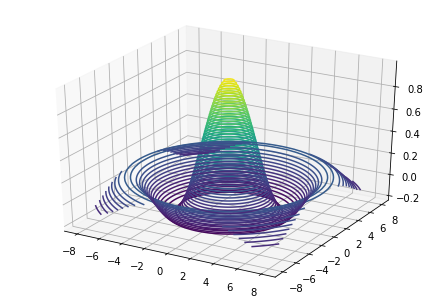

In [34]:
fig = plt.figure()
# 设置3D坐标轴
ax = Axes3D(fig)
# 根据网格点绘制sinc函数3D曲面
ax.contour3D(x.numpy(), y.numpy(), z.numpy(), 50)
plt.show()